In [ ]:
import pandas as pd

# Chargement du dataset fourni
file_path = '/content/data (1).csv'
df = pd.read_csv(file_path)

# Affichage des premières lignes du dataset
df.head()

,collection_name,name,description,kql_query,tactics,matched_columns
0,DeviceTvmSoftwareVulnerabilitiesKB_collection,Detect CISA Alert (AA22-117A) 2021 Top Routine...,This advanced hunting query detects CISA Alert...,// CISA Alert (AA22-117A) 2021 Top Routinely E...,['Execution'],"{'Severity': {'data_type': 'string', 'descript..."
1,DeviceTvmSoftwareVulnerabilitiesKB_collection,fireeye-red-team-tools-CVEs [Nobelium],Search for the CVEs that should be prioritized...,"let FireEyeCVE= dynamic(\n[\n""CVE-2019-11510"",...","['Privilege escalation', 'Vulnerability']","{'Severity': {'data_type': 'string', 'descript..."
2,EmailPostDeliveryEvents_collection,Threat actor Phosphorus masquerading as confer...,Identify prior activity from this campaign usi...,//Filter for emails that were delivered and ch...,['Initial access'],"{'NetworkMessageId': {'data_type': 'string', '..."
3,IdentityInfo_collection,devices_with_vuln_and_users_received_payload,// Author: jan geisbauer\n// @janvonkirchheim\...,let all_computers_with_vlcvln=\nDeviceTvmSoftw...,[],"{'DeviceName': {'data_type': 'string', 'descri..."
4,IdentityInfo_collection,LocalAdminGroupChanges,Author: alex verboon @alexverboon.\nBlogpost: ...,let ADAZUsers = IdentityInfo \n| extend Direc...,[],"{'Timestamp': {'data_type': 'datetime', 'descr..."


In [ ]:
print(df)

                        collection_name  \
0    DeviceTvmSoftwareVulnerabilitiesKB   
1    DeviceTvmSoftwareVulnerabilitiesKB   
2               EmailPostDeliveryEvents   
3                          IdentityInfo   
4                          IdentityInfo   
..                                  ...   
792                 IdentityQueryEvents   
793                 IdentityQueryEvents   
794                 IdentityQueryEvents   
795                 IdentityQueryEvents   
796               SecurityAlert (MDATP)   

                                                  name  \
0    Detect CISA Alert (AA22-117A) 2021 Top Routine...   
1               fireeye-red-team-tools-CVEs [Nobelium]   
2    Threat actor Phosphorus masquerading as confer...   
3         devices_with_vuln_and_users_received_payload   
4                               LocalAdminGroupChanges   
..                                                 ...   
792                                     PasswordSearch   
793                

In [ ]:
import re

def extract_comments_and_urls(query):
    comments = re.findall(r'//.*', query)  # Extraction des commentaires commençant par "//"
    urls = re.findall(r'(https?://\S+)', query)  # Extraction des URLs commençant par "http" ou "https"

    comments_text = " ".join(comments)
    urls_text = " ".join(urls)

    return comments_text, urls_text

# Fonction pour mettre à jour la description
def update_description(row):
    comments, urls = extract_comments_and_urls(row['kql_query'])
    additional_info = f"Comments: {comments}. URLs: {urls}."

    # Mise à jour de la colonne Description avec les informations supplémentaires
    if pd.isnull(row['description']):
        return additional_info
    else:
        return f"{row['description']} {additional_info}"

In [ ]:
df['description'] = df.apply(update_description, axis=1)

In [ ]:
def clean_kql(kql):
    # Supprimer les commentaires
    kql_cleaned = re.sub(r'//.*?$|/\*.*?\*/', '', kql, flags=re.DOTALL | re.MULTILINE)
    # Supprimer les URLs
    kql_cleaned = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', kql_cleaned)

    return kql_cleaned.strip()

In [ ]:
df['kql_query'] = df['kql_query'].apply(clean_kql)

In [ ]:
df.collection_name

0      DeviceTvmSoftwareVulnerabilitiesKB_collection
1      DeviceTvmSoftwareVulnerabilitiesKB_collection
2                 EmailPostDeliveryEvents_collection
3                            IdentityInfo_collection
4                            IdentityInfo_collection
                           ...                      
792                   IdentityQueryEvents_collection
793                   IdentityQueryEvents_collection
794                   IdentityQueryEvents_collection
795                   IdentityQueryEvents_collection
796                 SecurityAlert (MDATP)_collection
Name: collection_name, Length: 797, dtype: object

In [ ]:
def remove_collection_suffix(collection_name):
    if isinstance(collection_name, str):
        return collection_name.replace('_collection', '')
    return collection_name

# Appliquer la fonction à la colonne 'collection name'
df['collection_name'] = df['collection_name'].apply(remove_collection_suffix)


In [ ]:
df.collection_name

0      DeviceTvmSoftwareVulnerabilitiesKB
1      DeviceTvmSoftwareVulnerabilitiesKB
2                 EmailPostDeliveryEvents
3                            IdentityInfo
4                            IdentityInfo
                      ...                
792                   IdentityQueryEvents
793                   IdentityQueryEvents
794                   IdentityQueryEvents
795                   IdentityQueryEvents
796                 SecurityAlert (MDATP)
Name: collection_name, Length: 797, dtype: object

In [ ]:
df.to_csv('/content/dataclean.csv', index=False)

# **tactics visualisation**

<ipython-input-9-fc0d1b57e0be>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Tactic', data=tactics_df.sort_values(by='Count', ascending=False), palette='viridis')


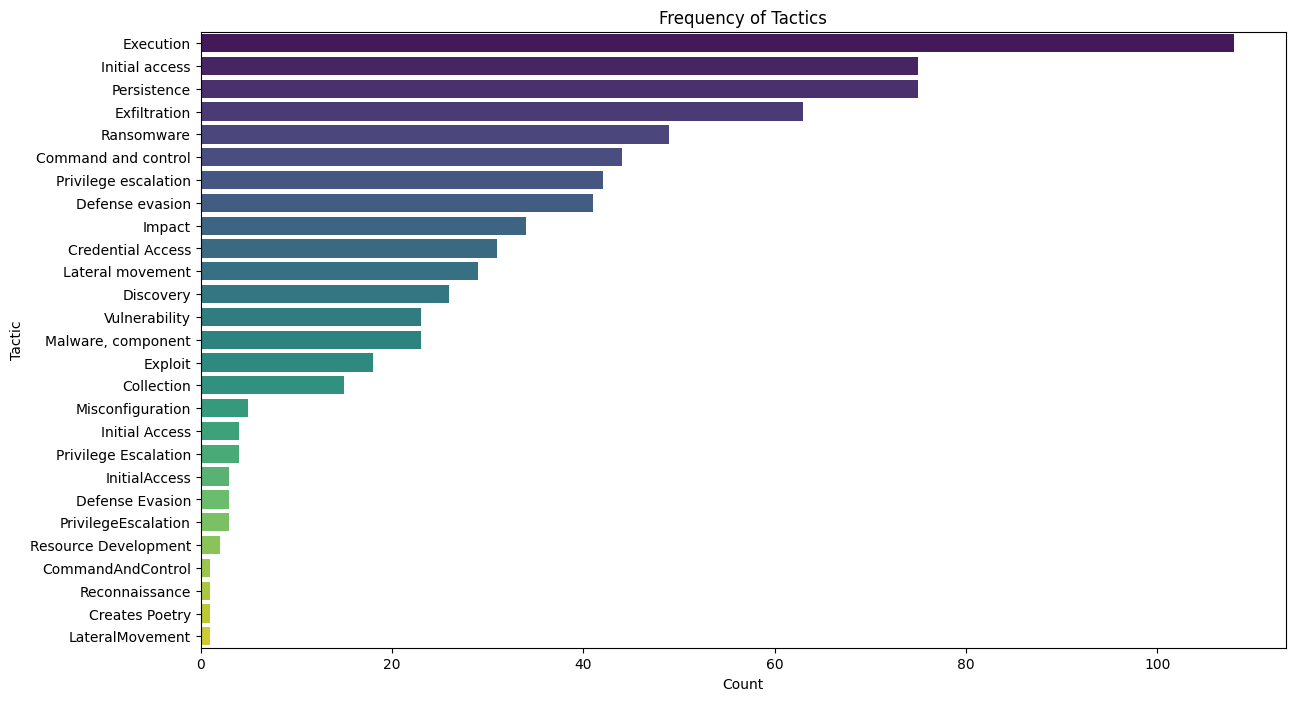

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast

def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

# Préparer les données pour la visualisation
df['tactics'] = df['tactics'].apply(lambda x: safe_eval(x) if pd.notna(x) else [])

# Aplatir les listes de tactiques et compter les occurrences de chaque tactique
all_tactics = [tactic for sublist in df['tactics'] for tactic in sublist]
tactics_count = Counter(all_tactics)

# Convertir le compteur en DataFrame
tactics_df = pd.DataFrame.from_dict(tactics_count, orient='index').reset_index()
tactics_df.columns = ['Tactic', 'Count']

# Tracer un graphique à barres pour la fréquence des tactiques
plt.figure(figsize=(14, 8))
sns.barplot(x='Count', y='Tactic', data=tactics_df.sort_values(by='Count', ascending=False), palette='viridis')
plt.title('Frequency of Tactics')
plt.xlabel('Count')
plt.ylabel('Tactic')
plt.show()

<ipython-input-66-f52f10f989aa>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tactics Status', y='Count', data=tactics_summary_df, palette='viridis')


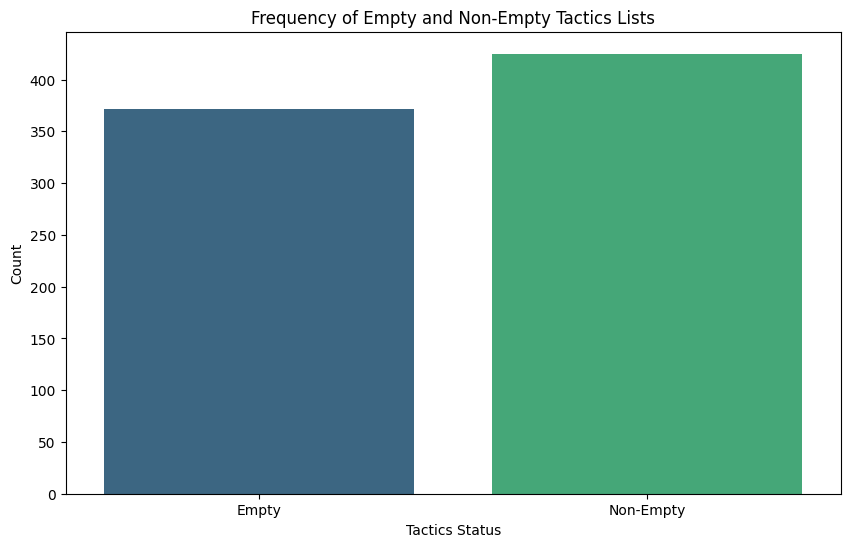

In [ ]:
# Fonction pour convertir les chaînes en listes de manière sécurisée
def safe_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    elif isinstance(x, list):
        return x
    else:
        return []

# Préparer les données pour la visualisation
df['tactics'] = df['tactics'].apply(safe_eval)

# Compter les listes vides et non vides
empty_tactics_count = df['tactics'].apply(lambda x: len(x) == 0).sum()
non_empty_tactics_count = df['tactics'].apply(lambda x: len(x) > 0).sum()

# Créer un DataFrame pour les résultats
tactics_summary_df = pd.DataFrame({
    'Tactics Status': ['Empty', 'Non-Empty'],
    'Count': [empty_tactics_count, non_empty_tactics_count]
})

# Tracer un graphique à barres pour les listes vides et non vides
plt.figure(figsize=(10, 6))
sns.barplot(x='Tactics Status', y='Count', data=tactics_summary_df, palette='viridis')
plt.title('Frequency of Empty and Non-Empty Tactics Lists')
plt.xlabel('Tactics Status')
plt.ylabel('Count')
plt.show()

# **Tactics/techniques**


In [ ]:
import requests
from bs4 import BeautifulSoup
import json

# URL de la page MITRE ATT&CK pour les tactiques
base_url = "https://attack.mitre.org"
tactics_url = f"{base_url}/tactics/enterprise/"

# Fonction pour scraper les tactiques et leurs descriptions
def scrape_tactics():
    response = requests.get(tactics_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    tactics = []
    tactics_list = soup.find_all('div', class_='card-content')
    for tactic in tactics_list:
        tactic_name = tactic.find('h3', class_='card-title').text.strip()
        tactic_description = tactic.find('div', class_='card-body').text.strip()
        tactic_url = base_url + tactic.find('a')['href']

        tactics.append({
            'Name': tactic_name,
            'Description': tactic_description,
            'URL': tactic_url
        })

    return tactics

# Fonction pour scraper les techniques et leurs descriptions pour une tactique
def scrape_techniques(tactic_url):
    response = requests.get(tactic_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    techniques = []
    techniques_section = soup.find('table', {'class': 'table techniques'})
    if techniques_section:
        for row in techniques_section.find_all('tr')[1:]:
            cols = row.find_all('td')
            technique_id = cols[0].text.strip()
            technique_name = cols[1].text.strip()
            technique_description = cols[2].text.strip()

            techniques.append({
                'ID': technique_id,
                'Name': technique_name,
                'Description': technique_description
            })

    return techniques



In [ ]:
# Scraper les tactiques
tactics = scrape_tactics()

# Scraper les techniques pour chaque tactique
for tactic in tactics:
    tactic_url = tactic['URL']
    tactic['Techniques'] = scrape_techniques(tactic_url)

# Sauvegarder les données en format JSON
with open('tactics_and_techniques.json', 'w') as f:
    json.dump(tactics, f, indent=4)

# Afficher les premières lignes du fichier JSON pour vérification
with open('tactics_and_techniques.json', 'r') as f:
    data = json.load(f)
    print(json.dumps(data, indent=4))

[]


In [ ]:
import json
import pandas as pd

# Charger les fichiers JSON
with open('/content/mitre_attack_db.tactics.json', 'r') as f:
    tactics_data = json.load(f)



# Convertir les listes JSON en DataFrames
tactics_df = pd.DataFrame(tactics_data)




In [ ]:
print("Tactics DataFrame columns:", tactics_df.columns)


Tactics DataFrame columns: Index(['_id', 'ID', 'Name', 'Description'], dtype='object')


In [ ]:
print(tactics_df)

                                     _id      ID                  Name  \
0   {'$oid': '65e8837ed134ae57db75bf9c'}  TA0043        Reconnaissance   
1   {'$oid': '65e8837ed134ae57db75bf9d'}  TA0042  Resource Development   
2   {'$oid': '65e8837ed134ae57db75bf9e'}  TA0001        Initial Access   
3   {'$oid': '65e8837ed134ae57db75bf9f'}  TA0002             Execution   
4   {'$oid': '65e8837ed134ae57db75bfa0'}  TA0003           Persistence   
5   {'$oid': '65e8837ed134ae57db75bfa1'}  TA0004  Privilege Escalation   
6   {'$oid': '65e8837ed134ae57db75bfa2'}  TA0005       Defense Evasion   
7   {'$oid': '65e8837ed134ae57db75bfa3'}  TA0006     Credential Access   
8   {'$oid': '65e8837ed134ae57db75bfa4'}  TA0007             Discovery   
9   {'$oid': '65e8837ed134ae57db75bfa5'}  TA0008      Lateral Movement   
10  {'$oid': '65e8837ed134ae57db75bfa6'}  TA0009            Collection   
11  {'$oid': '65e8837ed134ae57db75bfa7'}  TA0011   Command and Control   
12  {'$oid': '65e8837ed134ae57db75bfa8

In [ ]:
tactics_mapping = tactics_df.set_index(tactics_df['Name'].str.lower())['Description'].to_dict()
def add_tactic_descriptions(tactics_list):
    if isinstance(tactics_list, str):
        try:
            tactics_list = ast.literal_eval(tactics_list)
        except (ValueError, SyntaxError):
            return ''
    descriptions = [tactics_mapping.get(tactic.strip().lower(), '') for tactic in tactics_list if tactic]
    return ' '.join(descriptions)


In [ ]:

tactics_mapping

{'reconnaissance': 'The adversary is trying to gather information they can use to plan future operations.',
 'resource development': 'The adversary is trying to establish resources they can use to support operations.',
 'initial access': 'The adversary is trying to get into your network.',
 'execution': 'The adversary is trying to run malicious code.',
 'persistence': 'The adversary is trying to maintain their foothold.',
 'privilege escalation': 'The adversary is trying to gain higher-level permissions.',
 'defense evasion': 'The adversary is trying to avoid being detected.',
 'credential access': 'The adversary is trying to steal account names and passwords.',
 'discovery': 'The adversary is trying to figure out your environment.',
 'lateral movement': 'The adversary is trying to move through your environment.',
 'collection': 'The adversary is trying to gather data of interest to their goal.',
 'command and control': 'The adversary is trying to communicate with compromised systems t

In [ ]:
df.tactics

0                                [Execution]
1      [Privilege escalation, Vulnerability]
2                           [Initial access]
3                                         []
4                                         []
                       ...                  
792                                       []
793                                       []
794                                       []
795                                       []
796                                       []
Name: tactics, Length: 797, dtype: object

In [ ]:
df['tactics_descriptions'] = df['tactics'].apply(lambda x: add_tactic_descriptions(x) if isinstance(x, (str, list)) else '')


In [ ]:
df.tactics_descriptions

0         The adversary is trying to run malicious code.
1      The adversary is trying to gain higher-level p...
2      The adversary is trying to get into your network.
3                                                       
4                                                       
                             ...                        
792                                                     
793                                                     
794                                                     
795                                                     
796                                                     
Name: tactics_descriptions, Length: 797, dtype: object

In [ ]:
df

,collection_name,name,description,kql_query,tactics,matched_columns,tactics_descriptions
0,DeviceTvmSoftwareVulnerabilitiesKB,Detect CISA Alert (AA22-117A) 2021 Top Routine...,This advanced hunting query detects CISA Alert...,"let CISAAlertAA22117A= dynamic(\n[\n""CVE-2021-...",[Execution],"{'Severity': {'data_type': 'string', 'descript...",The adversary is trying to run malicious code.
1,DeviceTvmSoftwareVulnerabilitiesKB,fireeye-red-team-tools-CVEs [Nobelium],Search for the CVEs that should be prioritized...,"let FireEyeCVE= dynamic(\n[\n""CVE-2019-11510"",...","[Privilege escalation, Vulnerability]","{'Severity': {'data_type': 'string', 'descript...",The adversary is trying to gain higher-level p...
2,EmailPostDeliveryEvents,Threat actor Phosphorus masquerading as confer...,Identify prior activity from this campaign usi...,"let MaliciousSenders = dynamic([""t20saudiarabi...",[Initial access],"{'NetworkMessageId': {'data_type': 'string', '...",The adversary is trying to get into your network.
3,IdentityInfo,devices_with_vuln_and_users_received_payload,// Author: jan geisbauer\n// @janvonkirchheim\...,let all_computers_with_vlcvln=\nDeviceTvmSoftw...,[],"{'DeviceName': {'data_type': 'string', 'descri...",
4,IdentityInfo,LocalAdminGroupChanges,Author: alex verboon @alexverboon.\nBlogpost: ...,let ADAZUsers = IdentityInfo \n| extend Direc...,[],"{'Timestamp': {'data_type': 'datetime', 'descr...",
...,...,...,...,...,...,...,...
792,IdentityQueryEvents,PasswordSearch,Detect Active Directory LDAP queries that sear...,"let PersonObject = ""objectCategory=person"";\nl...",[],"{'Category': {'data_type': 'string', 'descript...",
793,IdentityQueryEvents,Roasting,Detect Active Directory LDAP queries that sear...,"let ASREP_ROASTING = ""userAccountControl:1.2.8...",[],"{'Timestamp': {'data_type': 'datetime', 'descr...",
794,IdentityQueryEvents,SensitiveLdaps,Detect Active Directory LDAP queries that sear...,"let SensitiveObjects = ""[\""Administrators\"", \...",[],"{'ActionType': {'data_type': 'string', 'descri...",
795,IdentityQueryEvents,VulnComputers,Detect Active Directory LDAP queries that try ...,"let ComputerObject = ""objectCategory=computer""...",[],"{'Category': {'data_type': 'string', 'descript...",


# **Keywords**

In [ ]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Télécharger les ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk import pos_tag, word_tokenize

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.corpus import stopwords
# Préparer les descriptions pour TF-IDF
descriptions = df['description'].fillna('')  # Remplacer les valeurs manquantes par des chaînes vides

# Récupérer les stop words en anglais
stop_words = set(stopwords.words('english'))

# Ajouter des mots spécifiques à exclure
additional_stop_words = set(['urls', 'query', 'microsoft', 'replace', 'list', 'provide', 'used', '2020', 'www', 'data','users','queries','comments','exe','cve'])

# Combiner les deux listes de stop words
combined_stop_words = list(stop_words.union(additional_stop_words))

# Initialiser TF-IDF Vectorizer avec les mots à exclure personnalisés
tfidf_vectorizer = TfidfVectorizer(stop_words=combined_stop_words, max_features=100)
# Fonction pour extraire les mots pertinents (noms, adjectifs, verbes)
def filter_pos(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    filtered_words = [word for word, pos in pos_tags if pos.startswith('NN') or pos.startswith('JJ') or pos.startswith('VB')]
    return ' '.join(filtered_words)

# Filtrer les descriptions pour ne garder que les mots pertinents
filtered_descriptions = descriptions.apply(filter_pos)

# Ajuster et transformer les descriptions filtrées
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_descriptions)

# Récupérer les mots-clés
def extract_keywords_tfidf(index, tfidf_matrix, feature_names, top_n=5):
    tfidf_scores = tfidf_matrix[index].toarray().flatten()
    top_indices = tfidf_scores.argsort()[-top_n:][::-1]
    top_keywords = [feature_names[i] for i in top_indices]
    return ', '.join(top_keywords)

# Récupérer les noms des caractéristiques (mots)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Ajouter une nouvelle colonne avec les mots-clés
df['keywords'] = [extract_keywords_tfidf(i, tfidf_matrix, feature_names) for i in range(tfidf_matrix.shape[0])]




In [ ]:
df.keywords

0             server, remote, alerts, command, windows
1                  file, remote, windows, find, github
2          filter, campaign, using, security, activity
3          devices, vulnerability, files, file, device
4                https, windows, file, device, devices
                            ...                       
792               user, windows, file, device, devices
793             process, get, windows, exploit, device
794    organization, windows, exploit, device, devices
795               find, windows, file, device, devices
796          names, defender, exploit, device, devices
Name: keywords, Length: 797, dtype: object

In [ ]:
df

,collection_name,name,description,kql_query,tactics,matched_columns,tactics_descriptions,keywords
0,DeviceTvmSoftwareVulnerabilitiesKB,Detect CISA Alert (AA22-117A) 2021 Top Routine...,This advanced hunting query detects CISA Alert...,"let CISAAlertAA22117A= dynamic(\n[\n""CVE-2021-...",[Execution],"{'Severity': {'data_type': 'string', 'descript...",The adversary is trying to run malicious code.,"server, remote, alerts, command, windows"
1,DeviceTvmSoftwareVulnerabilitiesKB,fireeye-red-team-tools-CVEs [Nobelium],Search for the CVEs that should be prioritized...,"let FireEyeCVE= dynamic(\n[\n""CVE-2019-11510"",...","[Privilege escalation, Vulnerability]","{'Severity': {'data_type': 'string', 'descript...",The adversary is trying to gain higher-level p...,"file, remote, windows, find, github"
2,EmailPostDeliveryEvents,Threat actor Phosphorus masquerading as confer...,Identify prior activity from this campaign usi...,"let MaliciousSenders = dynamic([""t20saudiarabi...",[Initial access],"{'NetworkMessageId': {'data_type': 'string', '...",The adversary is trying to get into your network.,"filter, campaign, using, security, activity"
3,IdentityInfo,devices_with_vuln_and_users_received_payload,// Author: jan geisbauer\n// @janvonkirchheim\...,let all_computers_with_vlcvln=\nDeviceTvmSoftw...,[],"{'DeviceName': {'data_type': 'string', 'descri...",,"devices, vulnerability, files, file, device"
4,IdentityInfo,LocalAdminGroupChanges,Author: alex verboon @alexverboon.\nBlogpost: ...,let ADAZUsers = IdentityInfo \n| extend Direc...,[],"{'Timestamp': {'data_type': 'datetime', 'descr...",,"https, windows, file, device, devices"
...,...,...,...,...,...,...,...,...
792,IdentityQueryEvents,PasswordSearch,Detect Active Directory LDAP queries that sear...,"let PersonObject = ""objectCategory=person"";\nl...",[],"{'Category': {'data_type': 'string', 'descript...",,"user, windows, file, device, devices"
793,IdentityQueryEvents,Roasting,Detect Active Directory LDAP queries that sear...,"let ASREP_ROASTING = ""userAccountControl:1.2.8...",[],"{'Timestamp': {'data_type': 'datetime', 'descr...",,"process, get, windows, exploit, device"
794,IdentityQueryEvents,SensitiveLdaps,Detect Active Directory LDAP queries that sear...,"let SensitiveObjects = ""[\""Administrators\"", \...",[],"{'ActionType': {'data_type': 'string', 'descri...",,"organization, windows, exploit, device, devices"
795,IdentityQueryEvents,VulnComputers,Detect Active Directory LDAP queries that try ...,"let ComputerObject = ""objectCategory=computer""...",[],"{'Category': {'data_type': 'string', 'descript...",,"find, windows, file, device, devices"


In [ ]:
# Supprimer la colonne 'matched_columns'
df1 = df.drop(columns=['matched_columns'])

In [ ]:

df1.to_csv('/content/dataii.csv', index=False)